# Snowflake for [DataMesh](https://www.snowflake.com/en/use-cases/data-mesh/)

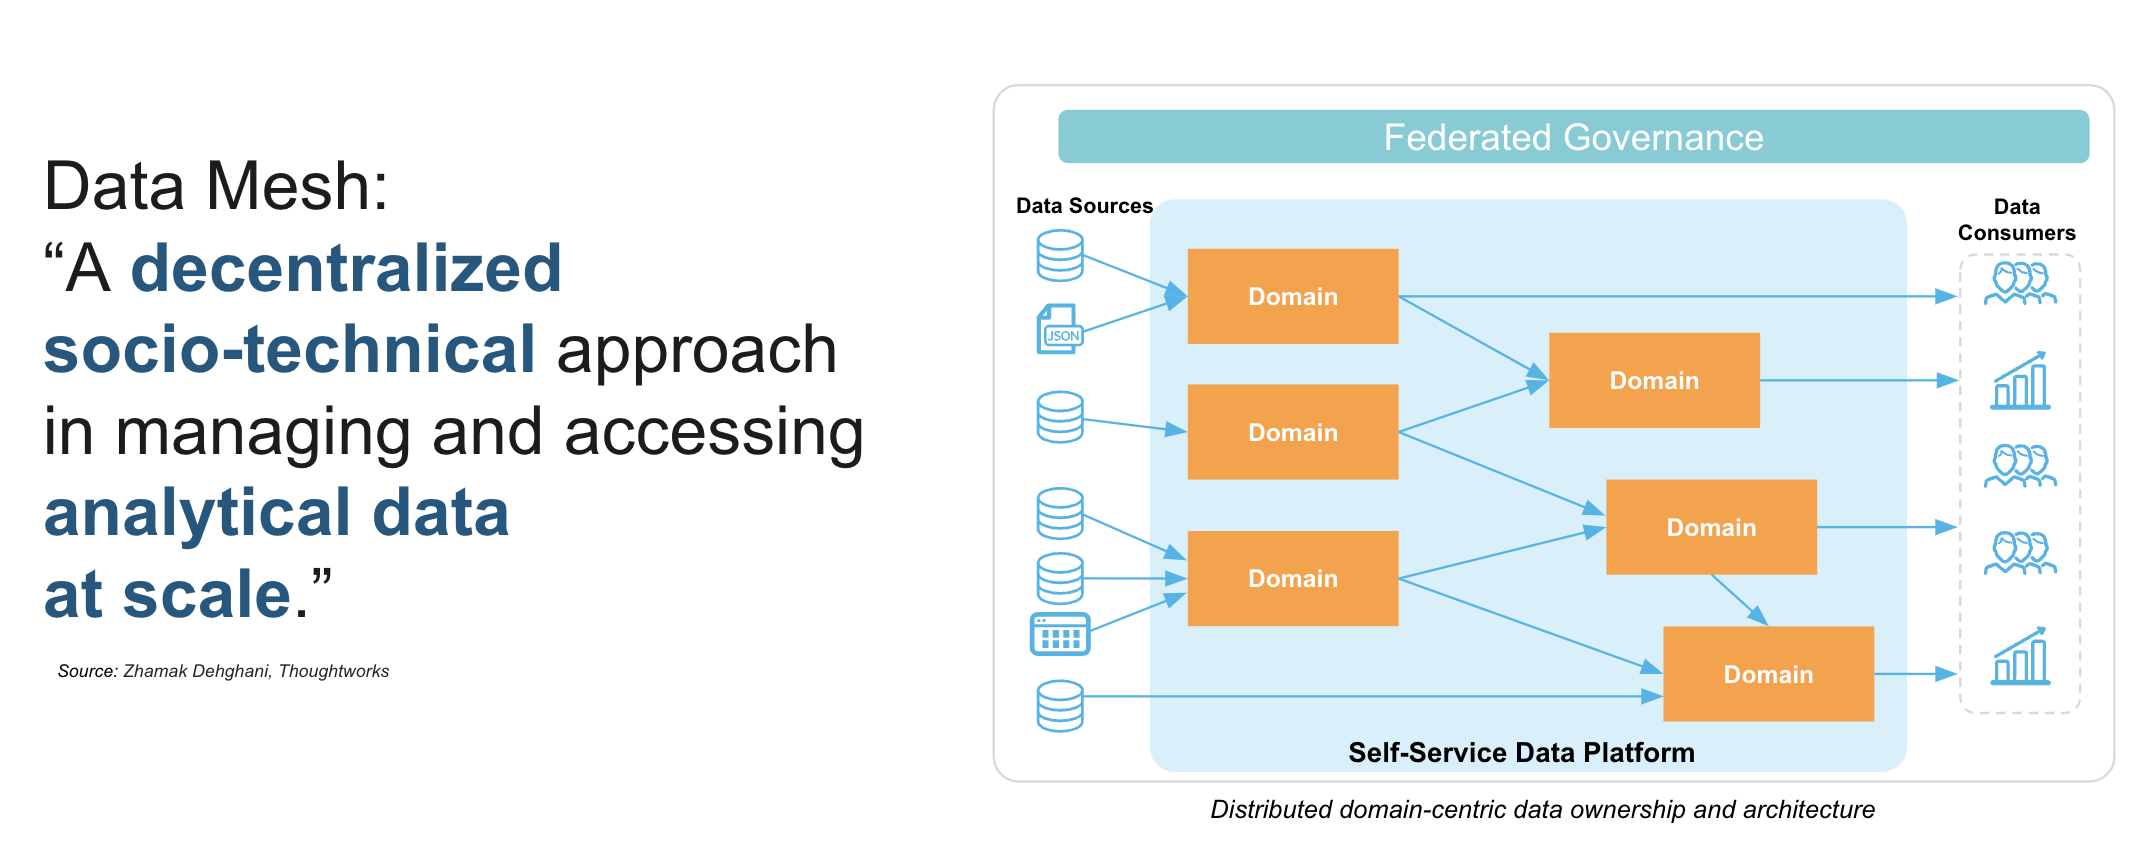

# SCENARIO WE ARE GOING TO COVER

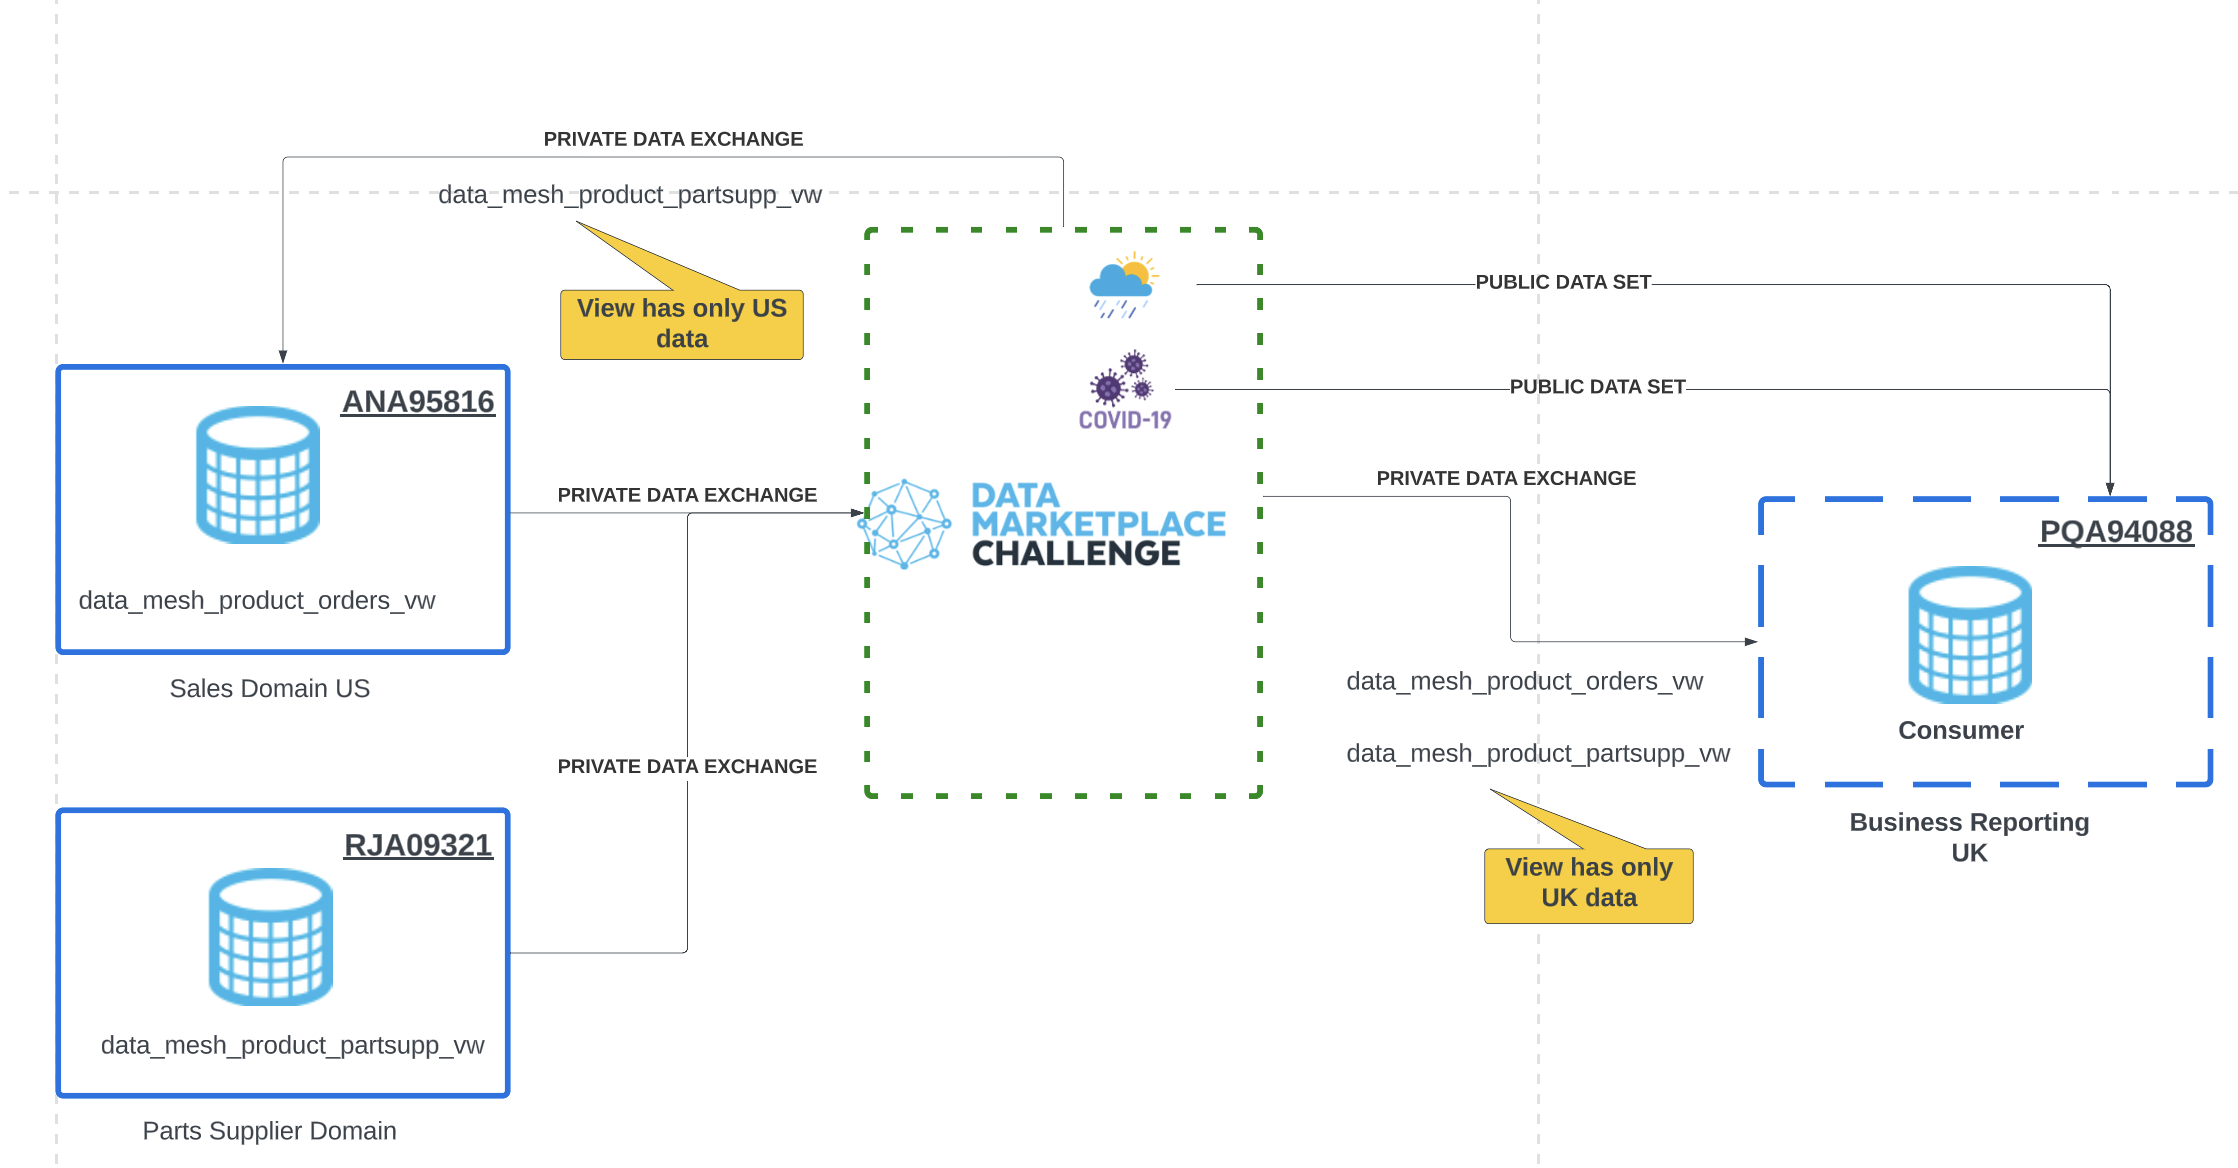

## <ins>Data Product 2 - Parts Supplier data from Procurement team</ins>

### CREATING DATAPRODUCT - data_mesh_product_partsupp_vw (view in Snowflake account VT70696)

In [1]:
# Establishing session in Snowflake
import snowflake.snowpark
from snowflake.snowpark.functions import sproc
from snowflake.snowpark.session import Session
from snowflake.snowpark import version as v
import json
from config_producer import snowflake_conn_prop_local as snowflake_udf_conn_prop

import pandas as pd
import numpy as np
import datetime
import io

session = Session.builder.configs(snowflake_udf_conn_prop).create()
print(session.sql('select current_account(), current_warehouse(), current_database(), current_schema()').collect())

session.add_packages('snowflake-snowpark-python', 'pandas', 'numpy')

[Row(CURRENT_ACCOUNT()='RJA09321', CURRENT_WAREHOUSE()='APP_WH', CURRENT_DATABASE()='BRONZE_LAYER', CURRENT_SCHEMA()='PUBLIC')]


In [2]:
session.sql("select current_account()").collect()

[Row(CURRENT_ACCOUNT()='RJA09321')]

In [3]:
#session.sql("").collect()

In [5]:
### SETUP ####
%time
session.sql("ALTER WAREHOUSE APP_WH SET WAREHOUSE_SIZE = 'X-LARGE';").collect() #-- For dataloading
#session.sql("create or replace database bronze_layer;").collect()
session.sql("CREATE OR REPLACE TABLE PARTSUPP as (SELECT * FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF100.PARTSUPP);;").collect()
session.sql("CREATE OR REPLACE TABLE PART as (SELECT * FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF100.PART);").collect()
session.sql("CREATE OR REPLACE TABLE supplier as (SELECT * FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF100.supplier);").collect()
session.sql("CREATE OR REPLACE TABLE NATION as (SELECT * FROM SNOWFLAKE_SAMPLE_DATA.TPCH_SF100.NATION);").collect()
session.sql("ALTER WAREHOUSE APP_WH SET WAREHOUSE_SIZE = 'X-SMALL';").collect() #-- For dataloading


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


[Row(status='Statement executed successfully.')]

In [8]:
### ROW LEVEL POLICY
session.sql("create or replace table SUPPLIERREGIONS ( ACCOUNT VARCHAR , \
ROLE VARCHAR, REGION VARCHAR  \
);").collect() 

session.sql("INSERT INTO SUPPLIERREGIONS VALUES  \
    ('PQA94088','RL_UK', 'UNITED KINGDOM'),  \
    ('ANA95816','RL_US', 'UNITED STATES');").collect()

#session.sql("ALTER VIEW DATA_MESH_PRODUCT_PARTSUPP_VW DROP ALL ROW ACCESS POLICIES;").collect()

session.sql("CREATE OR REPLACE ROW ACCESS POLICY SUPPLIER_POLICY AS (SUPPLY_REGION VARCHAR) RETURNS BOOLEAN -> (   \
        EXISTS (  \
            SELECT 1 FROM SUPPLIERREGIONS \
            WHERE \
                ACCOUNT = current_account() \
                AND region = supply_region \
        ) \
    );").collect()



[Row(status='Statement executed successfully.')]

In [25]:
%%time
session.sql("create or replace secure view DATA_MESH_PRODUCT_PARTSUPP_VW as \
            (select partsupp.ps_partkey, part.p_name, nat.n_name, sum(partsupp.ps_availqty) as available_quantity, \
            sum(partsupp.ps_supplycost) as total_cost_across_suppliers from PARTSUPP partsupp \
            join PART part on part.p_partkey = partsupp.ps_partkey \
            join supplier supp on supp.s_suppkey = partsupp.ps_suppkey \
            join NATION nat on supp.s_nationkey = nat.n_nationkey  \
group by partsupp.ps_partkey, part.p_name, nat.n_name order by sum(partsupp.ps_availqty), sum(partsupp.ps_supplycost) asc);").collect()

session.sql("alter view DATA_MESH_PRODUCT_PARTSUPP_VW add row access policy SUPPLIER_POLICY on (N_NAME);").collect()

CPU times: user 6.44 ms, sys: 2.35 ms, total: 8.79 ms
Wall time: 695 ms


[Row(status='Statement executed successfully.')]

In [26]:
## Data sharing
session.sql("CREATE OR REPLACE SHARE PARTSUPP_SHARE;").collect()
session.sql("grant usage on database BRONZE_LAYER to SHARE PARTSUPP_SHARE;;").collect()
session.sql("grant usage on schema BRONZE_LAYER.PUBLIC to SHARE PARTSUPP_SHARE;").collect()
session.sql("grant select on view  BRONZE_LAYER.PUBLIC.DATA_MESH_PRODUCT_PARTSUPP_VW to SHARE PARTSUPP_SHARE;").collect()
session.sql("ALTER SHARE PARTSUPP_SHARE ADD ACCOUNTS = PQA94088;").collect() #-- Update the account identifier



[Row(status='Statement executed successfully.')]

In [27]:
## Data sharing
session.sql("CREATE OR REPLACE SHARE PARTSUPP_SALES_SHARE;").collect()
session.sql("grant usage on database BRONZE_LAYER to SHARE PARTSUPP_SALES_SHARE;;").collect()
session.sql("grant usage on schema BRONZE_LAYER.PUBLIC to SHARE PARTSUPP_SALES_SHARE;").collect()
session.sql("grant select on view  BRONZE_LAYER.PUBLIC.DATA_MESH_PRODUCT_PARTSUPP_VW to SHARE PARTSUPP_SALES_SHARE;").collect()
session.sql("ALTER SHARE PARTSUPP_SALES_SHARE ADD ACCOUNTS = ANA95816;").collect() #-- Update the account identifier


[Row(status='Statement executed successfully.')]

In [29]:
if session:
    session.close()

KeyError: <snowflake.snowpark.session.Session object at 0x7fda980ba340>